In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd '//content/drive/MyDrive/Colab Notebooks/資工人工智慧/程式作業二'

/content/drive/MyDrive/Colab Notebooks/資工人工智慧/程式作業二


In [ ]:
!pip install diffimg

  Preparing metadata (setup.py) ... done
  Created wheel for diffimg: filename=diffimg-0.3.0-py3-none-any.whl size=4178 sha256=603e56050146503de659a8ff342096844341cb339585f17e4ac251aaf24074d8
  Stored in directory: /root/.cache/pip/wheels/b1/bd/a1/e64a65b2c908337fbd5563bf4487d791625c9750f4352abf7c
Successfully built diffimg


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageStat
import diffimg

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def show_imgs(xs, decoded_imgs):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xs[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
class CNN(Model):
  def __init__(self):
    super(CNN, self).__init__()

    self.encoder = tf.keras.Sequential([#建立神經網路
    layers.Conv2D(16, 3, activation='relu', padding='same', strides=1),
    #卷積，16個Filter, 每個kernel都為3x3, 激活函數為relu, padding至原大小, Filter每次移動1x1
    layers.MaxPooling2D((2, 2)),
    #最大池化層，以2x2為一個區塊取其中最大值
    layers.Conv2D(8, 3, activation='relu', padding='same', strides=1),
    layers.MaxPooling2D((2, 2)),
    ])

    self.decoder = tf.keras.Sequential([
    layers.UpSampling2D((2, 2)),
    #將一格像素放大為2x2，如[1]會變成[[1,1],[1,1]]
    layers.Conv2DTranspose(8, 3, strides=1, activation='relu', padding='same'),
    #反向卷積
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(16, 3, strides=1, activation='relu', padding='same'),
    layers.Conv2DTranspose(1, 3, strides=1, activation='sigmoid', padding='same'),
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder4 = CNN()
autoencoder4.build((32,28,28,1))

In [ ]:
#效果與上面兩格相同，單純測試將其整合，此儲存格可跳過，不需運行也可繼續操作
autoencoder4 = tf.keras.Sequential([
    layers.Conv2D(16, 3, activation='relu', padding='same', strides=1),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, 3, activation='relu', padding='same', strides=1),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(8, 3, strides=1, activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(16, 3, strides=1, activation='relu', padding='same'),
    layers.Conv2DTranspose(1, 3, strides=1, activation='sigmoid', padding='same'),
    ])

In [ ]:
autoencoder4.compile(optimizer='adam', loss='binary_crossentropy')
#優化器選用"adam"，損失方程選用"交叉熵損失函數"
history=autoencoder4.fit(x_train,x_train,#此為Autoencoder常見的訓練方式，目標是將輸入重建為輸出，因此x_train常被同時用於輸入與輸出，最小化兩者差異
    epochs=5,#將所有資料訓練5次
    batch_size=32, #小批次一次跑32筆資料
    shuffle=True, #每一次的epochs數據都會隨機洗亂
    validation_data=(x_test, x_test), #驗證集
    #正常會用"validation_split=0.2"，意為將最後的20%的資料作為驗證集，但mnist已經切好驗證集了，因此直接給驗證集就好
    )

Epoch 1/5
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0715 - val_loss: 0.0708
Epoch 2/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0713 - val_loss: 0.0705
Epoch 3/5
1875/1875 [==============================] - 135s 72ms/step - loss: 0.0711 - val_loss: 0.0705
Epoch 4/5
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0709 - val_loss: 0.0703
Epoch 5/5
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0708 - val_loss: 0.0701


In [ ]:
autoencoder4.encoder.summary() #單純用於了解模型

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder4.decoder.summary() #單純用於了解模型

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 8)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)       

encoded後，十條資料的大小為:(10, 7, 7, 8)
decoded後，十條資料的大小為:(10, 28, 28, 1)


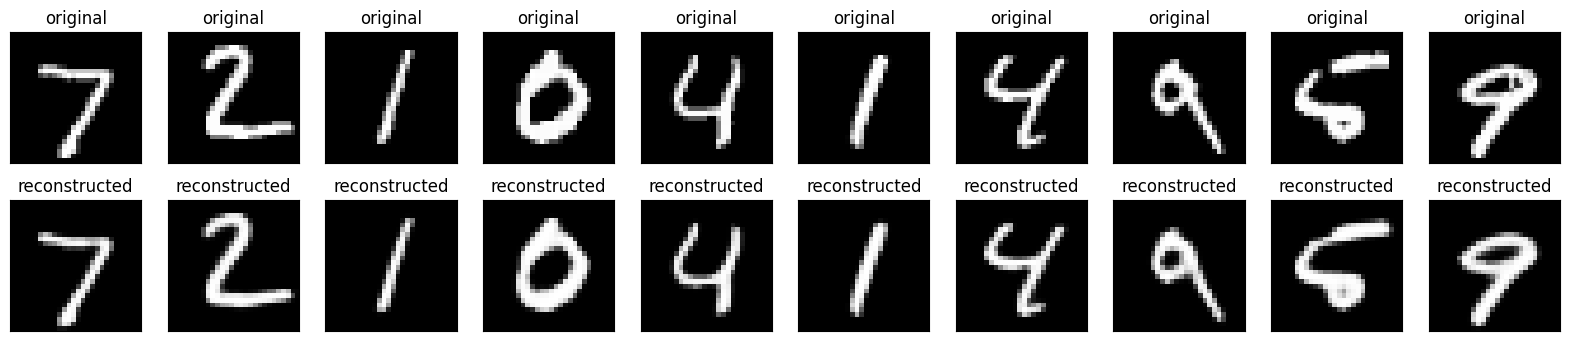

In [ ]:
x_test=x_test[:10]
encoded_imgs = autoencoder4.encoder(x_test) #將
print(f'encoded後，十條資料的大小為:{encoded_imgs.shape}')
decoded_imgs = autoencoder4.decoder(encoded_imgs)
print(f'decoded後，十條資料的大小為:{decoded_imgs.shape}')
x_test_3d = np.squeeze(x_test) #刪除多於維度
decoded_imgs_3d = np.squeeze(decoded_imgs)
show_imgs(x_test_3d, decoded_imgs_3d)
#將原本的資料與經過encoded→decoded後的資料做對比